In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import reuters
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import csv
import math
import gensim

from torch.nn.utils import clip_grad_norm_
import re
import pickle
import time
from tqdm import tqdm
from collections import Counter
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import nltk
nltk.download('reuters')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biswa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\biswa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\biswa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\biswa\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
C:\Users\biswa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [4]:
documents = reuters.fileids()
categories = reuters.categories()

train_docs = [doc for doc in documents if doc.startswith("training/")]
test_docs = [doc for doc in documents if doc.startswith("test/")]

In [5]:
train_sentences = [reuters.raw(doc_id) for doc_id in train_docs]
train_labels = [reuters.categories(doc_id) for doc_id in train_docs]

test_sentences = [reuters.raw(doc_id) for doc_id in test_docs]
test_labels = [reuters.categories(doc_id) for doc_id in test_docs]

In [6]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size = 0.2, random_state = 42)

In [7]:
def convert_to_labels(data_categories, unique_labels):
    binary_vectors = []
    for categories in data_categories:
        binary_vector = np.zeros(len(unique_labels), dtype=int)
        for category in categories:
            binary_vector[np.where(unique_labels == category)] = 1
        binary_vectors.append(binary_vector)

    binary_vectors = np.array(binary_vectors)
    return binary_vectors

In [8]:
unique_labels = np.concatenate(train_labels)
unique_labels = np.unique(unique_labels)

In [9]:
unique_labels.shape

(90,)

In [10]:
train_labels = convert_to_labels(train_labels, unique_labels)
val_labels = convert_to_labels(val_labels, unique_labels)
test_labels = convert_to_labels(test_labels, unique_labels)

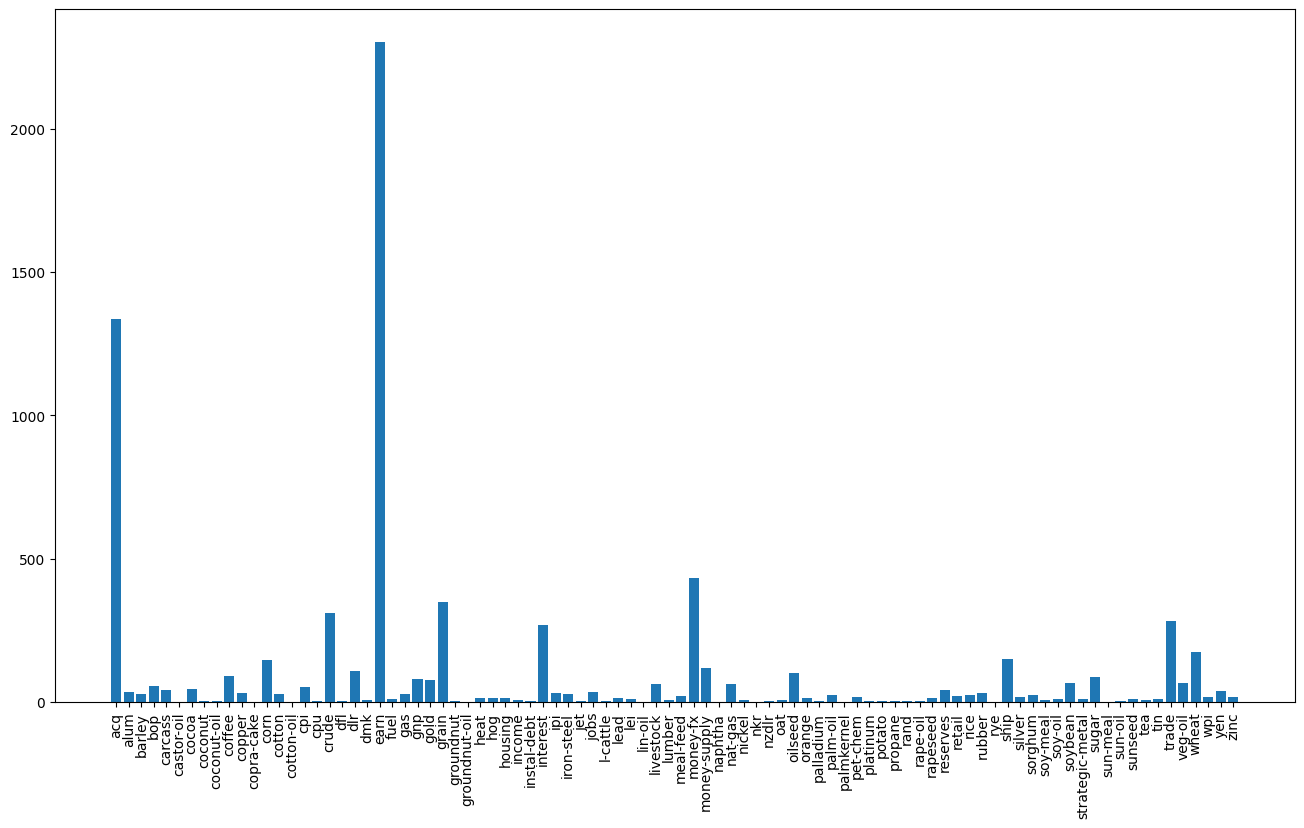

In [11]:
labels_count = [0] * 90

for label in train_labels:
    for i in range(len(label)):
        if label[i] == 1:
            labels_count[i] += 1

fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(unique_labels, labels_count)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [12]:
def data_preprocessing(sentences):

    tokenized_sentences = []
    for sentence in tqdm(sentences, desc = 'Tokenize'):
        sentence = sentence.lower()
        cleanr = re.compile('<.*?>')
        sentence = re.sub(cleanr, ' ', sentence)

        sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)
        sentence = sentence.strip()
        sentence = sentence.replace("\n"," ")
        sentence = re.sub(r'[^A-Za-z ]', '', sentence)
        sentence = re.sub('\s+', ' ', sentence)

        tokenized_sentences.append(nltk.word_tokenize(sentence))

    stop_words = set(stopwords.words('english'))

    removed_stop_words = []
    for sentence in tqdm(tokenized_sentences, desc = 'Stop_word_removal'):
        curr_sentence = []
        for token in sentence:
            if not token in stop_words:
                curr_sentence.append(token)
        
        removed_stop_words.append(curr_sentence)

    lemmatizer = WordNetLemmatizer()

    lemmatized_sentence = []
    for sentence in tqdm(removed_stop_words, desc = 'Lemmatization'):
        curr_sentence = []
        for token in sentence:
            curr_sentence.append(lemmatizer.lemmatize(token))

        lemmatized_sentence.append(curr_sentence)

    return lemmatized_sentence

In [13]:
def vocab_builder(sentences):
    # Word dictionary
    word_vocab = {}
    unique_id = 1
    for sentence in sentences:
        for word in sentence:
            if word not in word_vocab:
                word_vocab[word] = unique_id
                unique_id += 1

    word_vocab['<PAD>'] = 0
    word_vocab['<OOV>'] = unique_id

    return word_vocab

In [14]:
def text_to_sequence(sentences, word_vocab):

    text_sequence = []
    for sentence in sentences:
        curr_sequence = []
        for word in sentence:
            if word in word_vocab:
                curr_sequence.append(word_vocab[word])
            else:
                curr_sequence.append(word_vocab['<OOV>'])
        text_sequence.append(curr_sequence)

    return text_sequence

def pad_sequences(seq, maxlen):
    padded_seq = []
    if len(seq) < maxlen:
        padding_seq = [0] * (maxlen - len(seq))
        padded_seq = padding_seq + seq
    else:
        padded_seq = seq
        
    return padded_seq


def padding(sequence, max_length):
    new_sequence = []
    for i in range(len(sequence)):
        if len(sequence[i]) <= max_length:
            new_sequence.append(sequence[i])
        else:
            new_sequence.append(sequence[i][:max_length])
            

    sequence = new_sequence

    X = []
    for seq in tqdm(sequence, desc = 'Padding'):
        X.append(pad_sequences(seq, maxlen = max_length))

    return X

In [15]:
max_length = 200

In [16]:
# Train data
train_sentences = data_preprocessing(train_sentences)
word_vocab = vocab_builder(train_sentences)
vocab_size = len(word_vocab)
train_sequence = text_to_sequence(train_sentences, word_vocab)
train_sequence = padding(train_sequence, max_length)

X_train = np.array(train_sequence)
y_train = np.array(train_labels)

Padding: 100%|██████████| 6215/6215 [00:00<00:00, 534983.36it/s]


In [17]:
# Val data
val_sentences = data_preprocessing(val_sentences)
val_sequence = text_to_sequence(val_sentences, word_vocab)
val_sequence = padding(val_sequence, max_length)

X_val = np.array(val_sequence)
y_val = np.array(val_labels)

Padding: 100%|██████████| 1554/1554 [00:00<00:00, 517133.32it/s]


In [18]:
# Test data
test_sentences = data_preprocessing(test_sentences)
test_sequence = text_to_sequence(test_sentences, word_vocab)
test_sequence = padding(test_sequence, max_length)

X_test = np.array(test_sequence)
y_test = np.array(test_labels)

Padding: 100%|██████████| 3019/3019 [00:00<00:00, 410736.77it/s]


In [19]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(6215, 200) (6215, 90)
(1554, 200) (1554, 90)
(3019, 200) (3019, 90)


In [20]:
print(vocab_size, max_length)

23423 200


In [21]:
# save word2idx, maxlength
#change
with open('Reuters-21578_bert_model/word2idx.pkl', 'wb') as f:
    pickle.dump(word_vocab, f)

with open('Reuters-21578_bert_model/maxlength.pkl', 'wb') as f:
    pickle.dump(max_length, f)

In [22]:
class CustomDataset(Dataset):
    def __init__(self, sequence, labels):
        self.sequence = sequence
        self.labels = labels

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        sequence_in = torch.tensor(self.sequence[idx])
        output_label = torch.tensor(self.labels[idx]).float()
        return sequence_in, output_label

In [23]:
batch_size = 64

dataset_train = CustomDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = CustomDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = CustomDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [24]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
embeddings_dim = 768
pretrained_embeddings = []

for word in tqdm(word_vocab):
    if word in tokenizer.vocab:
        tokens = tokenizer.tokenize(word)
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_ids = [tokenizer.cls_token_id] + input_ids + [tokenizer.sep_token_id]
        input_ids = torch.tensor(input_ids).unsqueeze(0)
        outputs = bert_model(input_ids)
        token_embedding = outputs[0][0][1:-1].detach().tolist()
        token_embedding = np.array(token_embedding).reshape(embeddings_dim)
        pretrained_embeddings.append(token_embedding)
    else:
        token_embedding = ([0] * embeddings_dim)
        token_embedding = np.array(token_embedding)
        pretrained_embeddings.append(token_embedding)

100%|██████████| 23423/23423 [07:31<00:00, 51.87it/s] 


In [26]:
pretrained_embeddings = torch.Tensor(pretrained_embeddings)
print(pretrained_embeddings.shape)

torch.Size([23423, 768])


C:\Users\biswa\AppData\Local\Temp\ipykernel_1224\4288829487.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  pretrained_embeddings = torch.Tensor(pretrained_embeddings)


In [27]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, slope):
        super(GraphAttentionLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(out_features * 2, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(slope)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, h, adj):
        Wh = self.W(h)
        num_nodes = Wh.size(0)
        Whi = Wh.repeat_interleave(num_nodes, dim=0)
        Whj = Wh.repeat(num_nodes, 1)
        WhiWhj = torch.cat([Whi, Whj], dim=1)
        Whcat = WhiWhj.view(num_nodes, num_nodes, Wh.size(1) * 2)
        e = self.leakyrelu(self.a(Whcat).squeeze(2))
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = self.softmax(attention)
        h_hat = torch.mm(attention, Wh)
        return h_hat


class MAGNET(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        adjacency_matrix,
        node_embeddings,
        num_heads=4,
        slope=0.01,
        dropout=0.3,
    ):

        super(MAGNET, self).__init__()

        self.node_embedding = nn.Embedding.from_pretrained(node_embeddings)

        self.rnn = nn.LSTM(
            input_size, hidden_size, batch_first=True, bidirectional=True
        )

        self.attentions1 = nn.ModuleList(
            [
                GraphAttentionLayer(input_size, hidden_size * 2, slope)
                for _ in range(num_heads)
            ]
        )

        self.tanh1 = nn.Tanh()

        self.attentions2 = nn.ModuleList(
            [
                GraphAttentionLayer(hidden_size * 2, hidden_size * 2, slope)
                for _ in range(num_heads)
            ]
        )

        self.tanh2 = nn.Tanh()

        self.adjacency_matrix = nn.Parameter(adjacency_matrix)

        self.dropout = nn.Dropout(dropout)

    def forward(self, tokens, label_embedding):

        node_features = self.node_embedding(tokens).float()

        lstm_output, (hidden, _) = self.rnn(node_features)

        hidden_state = torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)

        hidden_state = self.dropout(hidden_state)

        heads_out1 = [
            att(label_embedding, self.adjacency_matrix) for att in self.attentions1
        ]

        head_out1_mean = self.tanh1(torch.stack(heads_out1, dim=0).mean(0))

        heads_out2 = [
            att(head_out1_mean, self.adjacency_matrix) for att in self.attentions2
        ]

        head_out2_mean = self.tanh2(torch.stack(heads_out2, dim=0).mean(0))

        attention = self.dropout(head_out2_mean)

        attention = attention.transpose(0, 1)

        output = torch.mm(hidden_state, attention)

        return output

In [28]:
def train_model(model, label_embedding, loss_function, optimizer, epochs, device, model_path):

    train_loss, val_loss = [], []
    total_time = 0
    min_average_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()

        print("Epoch : ", epoch + 1)

        model.to(device)
        model.train()
        total_train_loss = 0
        y_true_train, y_pred_train = [], []
        for batch in tqdm(dataloader_train, desc='Training'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            model.zero_grad()
            pred_batch = model(sequence_in, label_embedding)
            loss = loss_function(pred_batch, output_label)
            total_train_loss += loss.item()

            y_true_train.extend(output_label.cpu().detach().numpy().tolist())
            y_pred_train.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())

            loss.backward()
            
            clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
        

        model.eval()        
        total_val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for batch in tqdm(dataloader_val, desc='Evaluate'):
                sequence_in, output_label = batch
                sequence_in, output_label = sequence_in.to(device), output_label.to(device)

                pred_batch = model(sequence_in, label_embedding)
                loss = loss_function(pred_batch, output_label)
                total_val_loss += loss.item()

                y_true_val.extend(output_label.cpu().detach().numpy().tolist())
                y_pred_val.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())

        y_true_train = np.array(y_true_train)
        y_pred_train = np.array(y_pred_train)
        y_true_val = np.array(y_true_val)
        y_pred_val = np.array(y_pred_val)

        y_pred_train = y_pred_train >= 0.5
        y_pred_val = y_pred_val >= 0.5

        train_f1_score_micro = metrics.f1_score(y_true_train, y_pred_train, average='micro')
        val_f1_score_micro = metrics.f1_score(y_true_val, y_pred_val, average='micro')

        average_train_loss = float(total_train_loss / len(dataloader_train))
        average_val_loss = float(total_val_loss / len(dataloader_val))

        print('Train F1 Score (Micro)', train_f1_score_micro)
        print('Val F1 Score (Micro)', val_f1_score_micro)
        print('Train loss', average_train_loss)
        print('Val loss', average_val_loss)

        train_loss.append(average_train_loss)
        val_loss.append(average_val_loss)

        if average_val_loss < min_average_loss:
            min_average_loss = average_val_loss
            #change
            torch.save(model, "Reuters-21578_bert_model/" + model_path)
            print("Best model saved")
            
        print("------------------------------------------------")

        end_time = time.time()
        epoch_time = end_time - start_time
        total_time += epoch_time

    avg_epoch_time = total_time / epochs
    return train_loss, val_loss, avg_epoch_time

In [29]:
def buildAdjacencyCOOC(data_label):
  adj = data_label.T.dot(data_label).astype('float')
  
  for i in range(len(adj)):
    adj[i] = adj[i] / adj[i,i]
  
  return torch.from_numpy(adj.astype('float32'))

In [30]:
adjacency = buildAdjacencyCOOC(y_train)

In [31]:
label_embedding = torch.zeros(90, 768)

defined_labels = ['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa',
       'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn',
       'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk',
       'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut',
       'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt',
       'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead',
       'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx',
       'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nz-dlr',
       'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palm-kernel',
       'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil',
       'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship',
       'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean',
       'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sun-seed',
       'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']

for index, label in enumerate(defined_labels):
  words = label.split('-')
  num_of_words = len(words)
  
  for sublabel in words:
      if sublabel in tokenizer.vocab:
          tokens = tokenizer.tokenize(sublabel)
          input_ids = tokenizer.convert_tokens_to_ids(tokens)
          input_ids = [tokenizer.cls_token_id] + input_ids + [tokenizer.sep_token_id]
          input_ids = torch.tensor(input_ids).unsqueeze(0)
          outputs = bert_model(input_ids)
          token_embedding = outputs[0][0][1:-1].detach().tolist()
          token_embedding = np.array(token_embedding).reshape(embeddings_dim)
          label_embedding[index] +=  torch.from_numpy(token_embedding)
      
  label_embedding[index] = label_embedding[index]/num_of_words

label_embedding = label_embedding.float().to(device)
print(label_embedding, label_embedding.shape)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3520, -0.0208, -0.5637,  ...,  0.3664, -0.2522, -0.4625],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2010, -0.6140, -0.0010,  ...,  0.6233,  0.3900,  0.3414],
        [-0.7552, -0.1527, -0.2775,  ..., -0.1342, -0.0843,  0.0384]],
       device='cuda:0') torch.Size([90, 768])


In [32]:
#change
with open('Reuters-21578_bert_model/label_embedding.pkl', 'wb') as f:
    pickle.dump(label_embedding, f)

In [33]:
for word in label_embedding : 
    if(word[0] == 0) :
        print("Zero Labelling Check")

Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check
Zero Labelling Check


In [34]:
epochs = 70
learning_rate = 0.001

magnet_model_head_4 = MAGNET(768, 250, adjacency.to(device), pretrained_embeddings.to(device), num_heads = 4)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model_head_4.parameters(), lr = learning_rate)
train_loss_4, val_loss_4, avg_epoch_time_4 = train_model(magnet_model_head_4, label_embedding, loss_function, optimizer, epochs, device, "reuters_bert.pth")

Epoch :  1


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.61it/s]


Train F1 Score (Micro) 0.01595408895265423
Val F1 Score (Micro) 0.0
Train loss 0.1395069908122627
Val loss 0.06963658794760703
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.92it/s]


Train F1 Score (Micro) 0.0
Val F1 Score (Micro) 0.0
Train loss 0.06599076700453856
Val loss 0.05849420875310898
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 40.10it/s]


Train F1 Score (Micro) 0.11291090995712245
Val F1 Score (Micro) 0.30872483221476515
Train loss 0.05494766978889096
Val loss 0.05268735349178314
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.45it/s]


Train F1 Score (Micro) 0.32029365495542733
Val F1 Score (Micro) 0.37663986457892507
Train loss 0.050745062929178984
Val loss 0.04821195423603058
Best model saved
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 39.25it/s]


Train F1 Score (Micro) 0.3764753764753765
Val F1 Score (Micro) 0.40049958368026645
Train loss 0.04794059116013196
Val loss 0.04607490256428719
Best model saved
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 38.03it/s]


Train F1 Score (Micro) 0.401607232546459
Val F1 Score (Micro) 0.4123298638911128
Train loss 0.04515503573098353
Val loss 0.043336213529109956
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 38.14it/s]


Train F1 Score (Micro) 0.3971602434077079
Val F1 Score (Micro) 0.3885618166526492
Train loss 0.04354848716484041
Val loss 0.042999661341309545
Best model saved
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 39.89it/s]


Train F1 Score (Micro) 0.40388703310051627
Val F1 Score (Micro) 0.42242400315831036
Train loss 0.04184807361844851
Val loss 0.040292797312140465
Best model saved
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 38.08it/s]


Train F1 Score (Micro) 0.42385411532774764
Val F1 Score (Micro) 0.430622009569378
Train loss 0.03993507029906827
Val loss 0.041286502480506894
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.75it/s]


Train F1 Score (Micro) 0.44625719769673705
Val F1 Score (Micro) 0.4480961923847696
Train loss 0.03887030885231738
Val loss 0.037787533700466155
Best model saved
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.79it/s]


Train F1 Score (Micro) 0.4523764077113952
Val F1 Score (Micro) 0.4180698151950719
Train loss 0.0380088187259983
Val loss 0.0374391458183527
Best model saved
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.37it/s]


Train F1 Score (Micro) 0.5029101491451438
Val F1 Score (Micro) 0.5630457561997905
Train loss 0.035253608960430234
Val loss 0.03298423618078232
Best model saved
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.85it/s]


Train F1 Score (Micro) 0.528686327077748
Val F1 Score (Micro) 0.5867486338797815
Train loss 0.03419782937865476
Val loss 0.032382102757692335
Best model saved
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.76it/s]


Train F1 Score (Micro) 0.5570440416776113
Val F1 Score (Micro) 0.5832167832167833
Train loss 0.03369424345770052
Val loss 0.03251844979822636
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.98it/s]


Train F1 Score (Micro) 0.5839909808342729
Val F1 Score (Micro) 0.5748546511627907
Train loss 0.03180210946165785
Val loss 0.03034121632575989
Best model saved
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.46it/s]


Train F1 Score (Micro) 0.5917577217585822
Val F1 Score (Micro) 0.5862068965517242
Train loss 0.030626013856001045
Val loss 0.03024536557495594
Best model saved
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.12it/s]


Train F1 Score (Micro) 0.5987402110997616
Val F1 Score (Micro) 0.611344537815126
Train loss 0.029861611418654115
Val loss 0.028930883780121805
Best model saved
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.18it/s]


Train F1 Score (Micro) 0.6266599428475375
Val F1 Score (Micro) 0.6042857142857143
Train loss 0.028236579216484512
Val loss 0.02978850722312927
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.03it/s]


Train F1 Score (Micro) 0.6362801569413139
Val F1 Score (Micro) 0.6273830155979202
Train loss 0.027745963891549985
Val loss 0.02915218226611614
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.98it/s]


Train F1 Score (Micro) 0.6538049303322616
Val F1 Score (Micro) 0.641008174386921
Train loss 0.026843341533094645
Val loss 0.0275480205565691
Best model saved
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.96it/s]


Train F1 Score (Micro) 0.666503308012742
Val F1 Score (Micro) 0.6239436619718309
Train loss 0.026017733250877688
Val loss 0.028088097274303437
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.73it/s]


Train F1 Score (Micro) 0.674499635361802
Val F1 Score (Micro) 0.6564833672776645
Train loss 0.02486779574989056
Val loss 0.026155556738376617
Best model saved
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.96it/s]


Train F1 Score (Micro) 0.684323893099322
Val F1 Score (Micro) 0.6736703873933026
Train loss 0.02430154560894078
Val loss 0.025677337087690832
Best model saved
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 25/25 [00:01<00:00, 22.71it/s]


Train F1 Score (Micro) 0.6947752898205495
Val F1 Score (Micro) 0.6517857142857143
Train loss 0.023329016210853447
Val loss 0.026001819372177125
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.02it/s]


Train F1 Score (Micro) 0.7060309441111461
Val F1 Score (Micro) 0.7008871989860583
Train loss 0.02235099226616475
Val loss 0.024282368160784246
Best model saved
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.42it/s]


Train F1 Score (Micro) 0.7161089494163425
Val F1 Score (Micro) 0.6784996651038179
Train loss 0.021676393967045814
Val loss 0.02656812809407711
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.04it/s]


Train F1 Score (Micro) 0.7278632743020647
Val F1 Score (Micro) 0.7046496398166339
Train loss 0.02110170587251077
Val loss 0.023308541029691696
Best model saved
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.62it/s]


Train F1 Score (Micro) 0.7413488836031612
Val F1 Score (Micro) 0.7184713375796178
Train loss 0.020040597827221285
Val loss 0.02306264229118824
Best model saved
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.31it/s]


Train F1 Score (Micro) 0.7521626954014267
Val F1 Score (Micro) 0.7012435547467396
Train loss 0.019576188395446052
Val loss 0.02459766447544098
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.81it/s]


Train F1 Score (Micro) 0.7427747857088676
Val F1 Score (Micro) 0.7291203556684661
Train loss 0.020118937304965695
Val loss 0.023463262543082238
------------------------------------------------
Epoch :  31


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.67it/s]


Train F1 Score (Micro) 0.7535359614805899
Val F1 Score (Micro) 0.7377777777777778
Train loss 0.019044579035241385
Val loss 0.022534276396036147
Best model saved
------------------------------------------------
Epoch :  32


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.98it/s]


Train F1 Score (Micro) 0.7593342330184435
Val F1 Score (Micro) 0.7182823682498374
Train loss 0.01855747041539574
Val loss 0.024401883892714978
------------------------------------------------
Epoch :  33


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.12it/s]


Train F1 Score (Micro) 0.7706599286563615
Val F1 Score (Micro) 0.7276843467011643
Train loss 0.017360566858658378
Val loss 0.02223866917192936
Best model saved
------------------------------------------------
Epoch :  34


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.83it/s]


Train F1 Score (Micro) 0.7802311796087731
Val F1 Score (Micro) 0.7430535663133774
Train loss 0.0168099294663692
Val loss 0.023885141722857953
------------------------------------------------
Epoch :  35


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.73it/s]


Train F1 Score (Micro) 0.7842847647884204
Val F1 Score (Micro) 0.7532710280373831
Train loss 0.016811490092160448
Val loss 0.02349475644528866
------------------------------------------------
Epoch :  36


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.96it/s]


Train F1 Score (Micro) 0.7573682643643942
Val F1 Score (Micro) 0.7586837294332723
Train loss 0.018360639808281343
Val loss 0.02179818131029606
Best model saved
------------------------------------------------
Epoch :  37


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.90it/s]


Train F1 Score (Micro) 0.7843715444157758
Val F1 Score (Micro) 0.7513161969650045
Train loss 0.016919303172248965
Val loss 0.022301214560866357
------------------------------------------------
Epoch :  38


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.23it/s]


Train F1 Score (Micro) 0.7840458351696783
Val F1 Score (Micro) 0.7551333129022372
Train loss 0.01621015969787401
Val loss 0.02314817424863577
------------------------------------------------
Epoch :  39


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.89it/s]


Train F1 Score (Micro) 0.7968510824404111
Val F1 Score (Micro) 0.7409061901723037
Train loss 0.01573643332575353
Val loss 0.023566458858549594
------------------------------------------------
Epoch :  40


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.74it/s]


Train F1 Score (Micro) 0.7988088320743754
Val F1 Score (Micro) 0.7478152309612983
Train loss 0.015129418929620666
Val loss 0.022683213166892528
------------------------------------------------
Epoch :  41


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.71it/s]


Train F1 Score (Micro) 0.8063303945656888
Val F1 Score (Micro) 0.7504643962848297
Train loss 0.01473245366799588
Val loss 0.024395090490579606
------------------------------------------------
Epoch :  42


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.93it/s]


Train F1 Score (Micro) 0.8087170576310455
Val F1 Score (Micro) 0.7408829174664108
Train loss 0.014368223263977133
Val loss 0.023177969753742218
------------------------------------------------
Epoch :  43


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.33it/s]


Train F1 Score (Micro) 0.8036218761318362
Val F1 Score (Micro) 0.760928549894483
Train loss 0.014672164448860044
Val loss 0.02241160620003939
------------------------------------------------
Epoch :  44


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 30.53it/s]


Train F1 Score (Micro) 0.8157403418066926
Val F1 Score (Micro) 0.7651048088779284
Train loss 0.01386563175319865
Val loss 0.02155107893049717
Best model saved
------------------------------------------------
Epoch :  45


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 33.83it/s]


Train F1 Score (Micro) 0.8213978802635348
Val F1 Score (Micro) 0.7759626604434072
Train loss 0.013222793739631164
Val loss 0.020706232488155365
Best model saved
------------------------------------------------
Epoch :  46


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 31.51it/s]


Train F1 Score (Micro) 0.824759871931697
Val F1 Score (Micro) 0.7679708826205641
Train loss 0.012721329100658091
Val loss 0.021493065375834702
------------------------------------------------
Epoch :  47


Evaluate: 100%|██████████| 25/25 [00:01<00:00, 21.96it/s]


Train F1 Score (Micro) 0.8203524729960205
Val F1 Score (Micro) 0.7663663663663665
Train loss 0.012985811716097653
Val loss 0.02151215322315693
------------------------------------------------
Epoch :  48


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 32.46it/s]


Train F1 Score (Micro) 0.8246202125383354
Val F1 Score (Micro) 0.7642965204236005
Train loss 0.01305872917042247
Val loss 0.022934587113559245
------------------------------------------------
Epoch :  49


Evaluate: 100%|██████████| 25/25 [00:01<00:00, 14.32it/s]


Train F1 Score (Micro) 0.8285916489738147
Val F1 Score (Micro) 0.7725218439288943
Train loss 0.012559860127464849
Val loss 0.022573303282260895
------------------------------------------------
Epoch :  50


Evaluate: 100%|██████████| 25/25 [00:01<00:00, 22.73it/s]


Train F1 Score (Micro) 0.8326980093180856
Val F1 Score (Micro) 0.7809633027522935
Train loss 0.012091905177970017
Val loss 0.022059663385152816
------------------------------------------------
Epoch :  51


Evaluate: 100%|██████████| 25/25 [00:01<00:00, 18.53it/s]


Train F1 Score (Micro) 0.8365674255691768
Val F1 Score (Micro) 0.7882660470519895
Train loss 0.011785031327198506
Val loss 0.022299713268876076
------------------------------------------------
Epoch :  52


Evaluate: 100%|██████████| 25/25 [00:01<00:00, 22.12it/s]


Train F1 Score (Micro) 0.8449504120687247
Val F1 Score (Micro) 0.747141041931385
Train loss 0.011450633763012533
Val loss 0.02564084157347679
------------------------------------------------
Epoch :  53


Evaluate: 100%|██████████| 25/25 [00:01<00:00, 21.91it/s]


Train F1 Score (Micro) 0.8351339974743931
Val F1 Score (Micro) 0.7706478354313786
Train loss 0.01200622656829275
Val loss 0.022959116399288177
------------------------------------------------
Epoch :  54


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 39.12it/s]


Train F1 Score (Micro) 0.8447964429623455
Val F1 Score (Micro) 0.785692816351067
Train loss 0.011202311665960113
Val loss 0.02212223917245865
------------------------------------------------
Epoch :  55


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.34it/s]


Train F1 Score (Micro) 0.8409977703455964
Val F1 Score (Micro) 0.7900146842878121
Train loss 0.011498145991936326
Val loss 0.02134871942922473
------------------------------------------------
Epoch :  56


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 38.00it/s]


Train F1 Score (Micro) 0.8512230614649019
Val F1 Score (Micro) 0.7737804878048782
Train loss 0.01080205241142183
Val loss 0.0224250278249383
------------------------------------------------
Epoch :  57


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.68it/s]


Train F1 Score (Micro) 0.849065777592554
Val F1 Score (Micro) 0.7868755542417972
Train loss 0.010870250393351426
Val loss 0.021578704938292503
------------------------------------------------
Epoch :  58


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.76it/s]


Train F1 Score (Micro) 0.8509814763616257
Val F1 Score (Micro) 0.7796215429403203
Train loss 0.010625527734507104
Val loss 0.022839270494878293
------------------------------------------------
Epoch :  59


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.37it/s]


Train F1 Score (Micro) 0.8547643618851049
Val F1 Score (Micro) 0.7892785856857714
Train loss 0.010632764780893922
Val loss 0.022167311683297157
------------------------------------------------
Epoch :  60


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.83it/s]


Train F1 Score (Micro) 0.8561822423493893
Val F1 Score (Micro) 0.7557489123679304
Train loss 0.010492972924483332
Val loss 0.025109561011195183
------------------------------------------------
Epoch :  61


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 33.16it/s]


Train F1 Score (Micro) 0.8625991037573251
Val F1 Score (Micro) 0.7861870503597121
Train loss 0.009974895437172025
Val loss 0.023210490718483925
------------------------------------------------
Epoch :  62


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.39it/s]


Train F1 Score (Micro) 0.8637549787117155
Val F1 Score (Micro) 0.7918751839858699
Train loss 0.009844163161873514
Val loss 0.022606834694743158
------------------------------------------------
Epoch :  63


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.77it/s]


Train F1 Score (Micro) 0.8706236323851204
Val F1 Score (Micro) 0.7851677457327838
Train loss 0.0095118982527329
Val loss 0.023943505622446536
------------------------------------------------
Epoch :  64


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 30.94it/s]


Train F1 Score (Micro) 0.8664205633032541
Val F1 Score (Micro) 0.7888987304399172
Train loss 0.009747208117469385
Val loss 0.023048294782638548
------------------------------------------------
Epoch :  65


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.36it/s]


Train F1 Score (Micro) 0.8737850787132101
Val F1 Score (Micro) 0.7906020558002937
Train loss 0.008955591468720183
Val loss 0.02300532229244709
------------------------------------------------
Epoch :  66


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 38.01it/s]


Train F1 Score (Micro) 0.8740852198892005
Val F1 Score (Micro) 0.7887405687753918
Train loss 0.008951019442566594
Val loss 0.022622840497642755
------------------------------------------------
Epoch :  67


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.23it/s]


Train F1 Score (Micro) 0.8843832643927579
Val F1 Score (Micro) 0.7990762124711316
Train loss 0.00841160812557732
Val loss 0.02417994100600481
------------------------------------------------
Epoch :  68


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.90it/s]


Train F1 Score (Micro) 0.8830658812377277
Val F1 Score (Micro) 0.7946635730858469
Train loss 0.008630770820487594
Val loss 0.023793033845722674
------------------------------------------------
Epoch :  69


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.34it/s]


Train F1 Score (Micro) 0.8847195881874831
Val F1 Score (Micro) 0.7905727923627686
Train loss 0.008434938510395206
Val loss 0.02462572608143091
------------------------------------------------
Epoch :  70


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 31.40it/s]


Train F1 Score (Micro) 0.8805909460558417
Val F1 Score (Micro) 0.7893054344667247
Train loss 0.008535909176595052
Val loss 0.02473763030022383
------------------------------------------------


# Evaluation

In [35]:
def test_scores(model, device):

    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader_test, desc='Evaluate'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            pred_batch = model(sequence_in, label_embedding)
            pred_batch = (pred_batch > 0.5).float()

            y_true.extend(output_label.cpu().detach().numpy().tolist())
            y_pred.extend(pred_batch.cpu().detach().numpy().tolist())


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1_score_micro = metrics.f1_score(y_true, y_pred, average='micro')

    print('Test Accuracy', accuracy)
    print('Test F1 Score (Micro)', f1_score_micro)

    print('Classification report')
    print(classification_report(y_true, y_pred, zero_division=0))

In [36]:
best_model_4 = torch.load("Reuters-21578_bert_model/reuters_bert.pth")
test_scores(best_model_4, device)

Evaluate: 100%|██████████| 48/48 [00:01<00:00, 34.11it/s]


Test Accuracy 0.6813514408744618
Test F1 Score (Micro) 0.7534516765285996
Classification report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       719
           1       0.00      0.00      0.00        23
           2       0.50      0.07      0.12        14
           3       0.46      0.20      0.28        30
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        28
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00         1
          12       0.47      0.71      0.56        56
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00         2
          15       0.33      0.04      

In [37]:
num_params = sum(p.numel() for p in best_model_4.parameters() if p.requires_grad) 

print(best_model_4)
print(f'The model has {num_params:,} trainable parameters')

MAGNET(
  (node_embedding): Embedding(23423, 768)
  (rnn): LSTM(768, 250, batch_first=True, bidirectional=True)
  (attentions1): ModuleList(
    (0-3): 4 x GraphAttentionLayer(
      (W): Linear(in_features=768, out_features=500, bias=False)
      (a): Linear(in_features=1000, out_features=1, bias=False)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (softmax): Softmax(dim=1)
    )
  )
  (tanh1): Tanh()
  (attentions2): ModuleList(
    (0-3): 4 x GraphAttentionLayer(
      (W): Linear(in_features=500, out_features=500, bias=False)
      (a): Linear(in_features=1000, out_features=1, bias=False)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (softmax): Softmax(dim=1)
    )
  )
  (tanh2): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
)
The model has 4,592,100 trainable parameters


In [38]:
print('Train loss', train_loss_4)
print('Val loss', val_loss_4)

Train loss [0.1395069908122627, 0.06599076700453856, 0.05494766978889096, 0.050745062929178984, 0.04794059116013196, 0.04515503573098353, 0.04354848716484041, 0.04184807361844851, 0.03993507029906827, 0.03887030885231738, 0.0380088187259983, 0.035253608960430234, 0.03419782937865476, 0.03369424345770052, 0.03180210946165785, 0.030626013856001045, 0.029861611418654115, 0.028236579216484512, 0.027745963891549985, 0.026843341533094645, 0.026017733250877688, 0.02486779574989056, 0.02430154560894078, 0.023329016210853447, 0.02235099226616475, 0.021676393967045814, 0.02110170587251077, 0.020040597827221285, 0.019576188395446052, 0.020118937304965695, 0.019044579035241385, 0.01855747041539574, 0.017360566858658378, 0.0168099294663692, 0.016811490092160448, 0.018360639808281343, 0.016919303172248965, 0.01621015969787401, 0.01573643332575353, 0.015129418929620666, 0.01473245366799588, 0.014368223263977133, 0.014672164448860044, 0.01386563175319865, 0.013222793739631164, 0.012721329100658091, 0.

In [ ]:
print('Avg epoch time', round(avg_epoch_time_4, 2), 'secs')